# NBA Data Analysis 3 :: Win Classification Models

###### Abhishek Menothu, Johnathen Wigfall, Scott Campbell, Trevor Rowland

## Executive Summary, Business Context

This notebook aims to create classification models to predict wins in NBA games given summary statistics of a game. Using these models, coaches, teams, and organizations can examine the predictor variables with high predictive weight in classifying a win or loss, and can focus on improving those statistics to drive more wins.

**GO BACK AND MODIFY WITH INSIGHTS, THIS SHOULD EXPLAIN THE PRESENTATION WITHOUT HAVING TO SCROLL FURTHER**

## Data Overview

The data used is NBA Box Scores collected from 2004-2024, and filtered down to 2013-2024. This filtering was done due to weaker data in the older seasons and poor data collection from the NBA. The data is accessed from a google drive folder, and can be seen below.

**ADD A SUMMARY HERE. WE...**
- Drop NA Data
- Remove ID Values
- Remove Postgame Totals with high predictive power

In [1]:
# Import Packages
import pandas as pd
import numpy as np

# Collect Data from Google Drive
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')

# Filter Data to 2013-2024
df = df[df['season'].str[:4].astype(int) > 2012] # Remove old seasons (only keeping seasons 2013-14 onward)
#df = df.loc[(df['distance'] != 0 ) & (df['touches'] != 0)] # exclude rows where 0 in certain columns doesnt make sense
df = df.dropna() # drop rows with missing values 
df = df.reset_index(drop=True) # reset index
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,41300405,2013-14,1610612759,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,...,0.475,0.474,15.0,24.0,0.625,87.0,1,1,1,0
1,41300404,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,71.0,0.451,...,0.439,0.451,16.0,19.0,0.842,107.0,1,0,1,0
2,41300403,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,62.0,0.516,...,0.516,0.516,14.0,20.0,0.700,111.0,1,0,1,0
3,41300402,2013-14,1610612759,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,...,0.452,0.439,17.0,24.0,0.708,98.0,1,0,1,0
4,41300401,2013-14,1610612759,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,...,0.472,0.588,12.0,21.0,0.571,95.0,1,1,1,0


### Cleaning Data

We can also drop ID variables like `game_id`, `team_id`, etc. Additionally, we will drop variables like `points`, `three_pointers_made`, or `plus_minus_points` that are rolling amounts during the game, but in our data are postgame totals, with extremely high predictive power. Because of this high predictive power, they must be removed to prevent overfitting.

In [2]:
try:
    drop_vars = [
        'game_id', 
        'team_id', 
        'team_name', 
        'tri_code', 
        'team_slug', 
        'season', # dropping for now but could technically be a cat dep var
        'minutes'] + ['points', 'opponent_points', 'plus_minus_points','field_goals_made',
'three_pointers_made',
'free_throws_made',
'contested_field_goals_made',
'uncontested_field_goals_made',
'defended_at_rim_field_goals_made']
    df = df.drop(drop_vars, axis=1)
    df.head()
except Exception as e:
    print('drop_vars already dropped')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   field_goals_attempted                  30060 non-null  float64
 1   field_goals_percentage                 30060 non-null  float64
 2   three_pointers_attempted               30060 non-null  float64
 3   three_pointers_percentage              30060 non-null  float64
 4   free_throws_attempted                  30060 non-null  float64
 5   free_throws_percentage                 30060 non-null  float64
 6   rebounds_offensive                     30060 non-null  float64
 7   rebounds_defensive                     30060 non-null  float64
 8   rebounds_total                         30060 non-null  float64
 9   steals                                 30060 non-null  float64
 10  blocks                                 30060 non-null  float64
 11  tu

Lastly, we can drop `is_playoff_game`. This variable is redundant, as we already have a variable `is_regular_game` that, if 0, means the game is a playoff game.

In [3]:
cat_vars = ['is_home_team', 'won_game', 'is_regular_game']
df_cat = df[cat_vars]
df_num = df.drop(cat_vars, axis=1)

# assertion to ensure that split happened properly
assert df_cat.shape[1] + df_num.shape[1] == df.shape[1]

### Removing High Correlation and Near-Zero Variance

In [4]:
# From John's notebook
def removeHighCorr (data,thresh):
  from dython.nominal import associations
  corr_matrix=associations(dataset=data, compute_only=True)['corr'].abs()
  upper_tri=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
  to_drop=[column for column in upper_tri.columns if any(upper_tri[column]>thresh)]
  new_data=data.drop(to_drop,axis=1)
  return new_data

In [5]:
pre = df_num.shape[1]
df_num_nhc = removeHighCorr(df_num, 0.7) # _nhc --> no high corr
post = len(df_num_nhc.columns.tolist())

print(f'pre: {pre} \n post: {post}')

pre: 53 
 post: 26


And now we remove NZV.

In [6]:
pre = post

from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.1)
vt.fit_transform(df_num_nhc)

cols = df_num_nhc.columns[vt.get_support()]
post = len(cols)

df_num_nhc_nnzv = df_num_nhc[cols] # _nnzv --> no near zero variance

print(f'pre: {pre} \n post: {post}')

pre: 26 
 post: 17


And now we can take a look at the finished dataframe.

In [7]:
df_num_nhc_nnzv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   field_goals_attempted       30060 non-null  float64
 1   three_pointers_attempted    30060 non-null  float64
 2   free_throws_attempted       30060 non-null  float64
 3   rebounds_offensive          30060 non-null  float64
 4   rebounds_defensive          30060 non-null  float64
 5   steals                      30060 non-null  float64
 6   blocks                      30060 non-null  float64
 7   turnovers                   30060 non-null  float64
 8   fouls_personal              30060 non-null  float64
 9   estimated_defensive_rating  30060 non-null  float64
 10  estimated_net_rating        30060 non-null  float64
 11  estimated_pace              30060 non-null  float64
 12  pace                        30060 non-null  float64
 13  distance                    300

Lastly, we can recombine the split categorical and numeric data into the final dataframe for the model.

In [8]:
df_full = pd.concat([df_num_nhc_nnzv.reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

# checks to make sure merge happened properly since past experience as shown that incorrect merge will mess up the fitting

# assertion for row size (since feature elimination did not touch rows and only bad merge would mess it up)
assert df_full.shape[0] == df.shape[0] # df is right before split into _cat/_num 

# assertion for nulls (since nulls were cleaned out before feature elimination) 
assert df_full.isna().sum().sum() == 0

In [9]:
# Check for Class Imbalance (We should see around a 50/50 split)
ct = pd.crosstab(index=df_full['won_game'], columns='count')
ct_norm = ct / ct.sum() # to show percentages
ct_norm

col_0,count
won_game,
0,0.5
1,0.5


## Model Building

Now that the data has been preprocessed, we can create the models for the analysis. We will be using the following models:

- Logistic Regression (LR)
- Decision Trees (DT)
- Random Forest (RF)
- Support Vector Machines (SVM)
- Adaptive Neural Networks (ANN)
- XGBoost (XGB)

### Test-Train Split

In [10]:
dep_var_name = 'won_game'

dep_var = df_full[dep_var_name]
ind_var = df_full.drop([dep_var_name], axis=1)

# data partitioning
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(ind_var, dep_var, test_size=0.2, random_state=42)

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

### Logistic Regression Model

In [12]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='liblinear', random_state=42).fit(train_X, train_y)

lr_class = lr_model.predict(test_X)
lr_acc = accuracy_score(test_y, lr_class)
lr_mis = 1 - lr_acc

### Decision Tree Model

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3).fit(train_X, train_y)
dt_class = dt_model.predict(test_X)
dt_acc = accuracy_score(test_y, dt_class)
dt_mis = 1 - dt_acc

### Random Forest Model

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, max_depth=3).fit(train_X, train_y)

rf_class = rf_model.predict(test_X)
rf_acc = accuracy_score(test_y, rf_class)
rf_mis = 1 - rf_acc

### SVM Model

In [15]:
from sklearn.svm import SVC
svm_model = SVC(random_state=50).fit(train_X, train_y)

svm_class = svm_model.predict(test_X)
svm_acc = accuracy_score(test_y, svm_class)
svm_mis = 1 - svm_acc

### ANN Model

In [16]:
from sklearn.neural_network import MLPClassifier
ann_model = MLPClassifier(hidden_layer_sizes=3,
                    random_state=50,
                    activation='logistic',
                    solver='lbfgs',
                    max_iter=400).fit(train_X, train_y)

ann_class = ann_model.predict(test_X)
ann_acc = accuracy_score(test_y, ann_class)
ann_mis = 1 - ann_acc

### XGBoost Model

In [30]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss',
                          n_estimators=5, 
                          max_depth=5, 
                          learning_rate=.1).fit(train_X, train_y)

xgb_class = xgb_model.predict(test_X)
xgb_acc = accuracy_score(test_y, xgb_class)
xgb_mis = 1 - xgb_acc

## Model Evaluation

### Accuracy and Misclassification Table



In [31]:
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'ANN', 'XGBoost'],
    'Accuracy': [lr_acc, dt_acc, rf_acc, svm_acc, ann_acc, xgb_acc],
    'Misclassification Rate': [lr_mis, dt_mis, rf_mis, svm_mis, ann_mis, xgb_mis]
}

df_acc_mis = pd.DataFrame(data)
df_acc_mis


,Model,Accuracy,Misclassification Rate
0,Logistic Regression,0.963906,0.036094
1,Decision Tree,0.961910,0.038090
2,Random Forest,0.962409,0.037591
3,SVM,0.963573,0.036427
4,ANN,0.497671,0.502329
5,XGBoost,0.959581,0.040419


### ROC Curves and AUC Score

In [32]:
lr_auc = roc_auc_score(test_y, lr_class)
dt_auc = roc_auc_score(test_y, dt_class)
rf_auc = roc_auc_score(test_y, rf_class)
svm_auc = roc_auc_score(test_y, svm_class)
ann_auc = roc_auc_score(test_y, ann_class)
xgb_auc = roc_auc_score(test_y, xgb_class)

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_class)
dt_fpr, dt_tpr, _ = roc_curve(test_y, dt_class)
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_class)
svm_fpr, svm_tpr, _ = roc_curve(test_y, svm_class)
ann_fpr, ann_tpr, _ = roc_curve(test_y, ann_class)
xgb_fpr, xgb_tpr, _ = roc_curve(test_y, xgb_class)

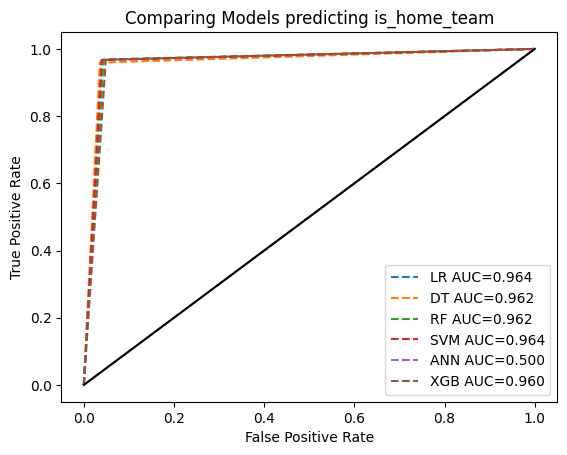

In [20]:
import matplotlib.pyplot as plt

plt.plot(lr_fpr, lr_tpr, linestyle='--', label='{}{:.3f}'.format("LR AUC=", lr_auc))
plt.plot(dt_fpr, dt_tpr, linestyle='--', label='{}{:.3f}'.format("DT AUC=", dt_auc))
plt.plot(rf_fpr, rf_tpr, linestyle='--', label='{}{:.3f}'.format("RF AUC=", rf_auc))
plt.plot(svm_fpr, svm_tpr, linestyle='--', label='{}{:.3f}'.format("SVM AUC=", svm_auc))
plt.plot(ann_fpr, ann_tpr, linestyle='--', label='{}{:.3f}'.format("ANN AUC=", ann_auc))
plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label='{}{:.3f}'.format("XGB AUC=", xgb_auc))
plt.plot([0,1], [0,1], linestyle='solid', c='k')


plt.title('Comparing Models predicting is_home_team')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Learning Rates

### Logistic Regression

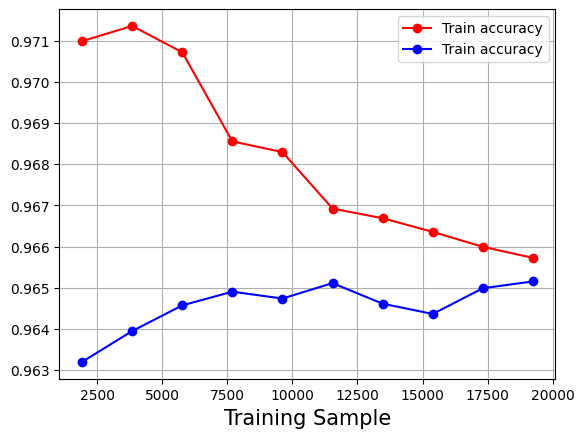

In [23]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=lr_model, 
                                                 X=train_X, 
                                                 y=train_y, 
                                                 train_sizes=np.linspace(.1,1,10),cv=5,
                                                 n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r',marker='o',label='Train accuracy')
plt.plot(size, test_mean, color='b',marker='o',label='Train accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.grid()
plt.legend(loc='upper right')
plt.show()

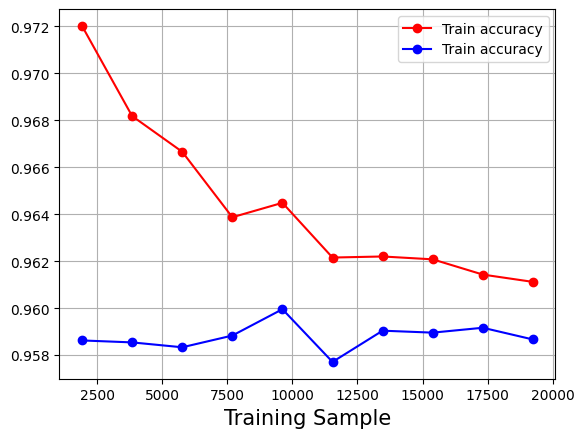

In [25]:
size, train_scores, test_scores = learning_curve(estimator=dt_model, 
                                                 X=train_X, 
                                                 y=train_y, 
                                                 train_sizes=np.linspace(.1,1,10),cv=5,
                                                 n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r',marker='o',label='Train accuracy')
plt.plot(size, test_mean, color='b',marker='o',label='Train accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.grid()
plt.legend(loc='upper right')
plt.show()

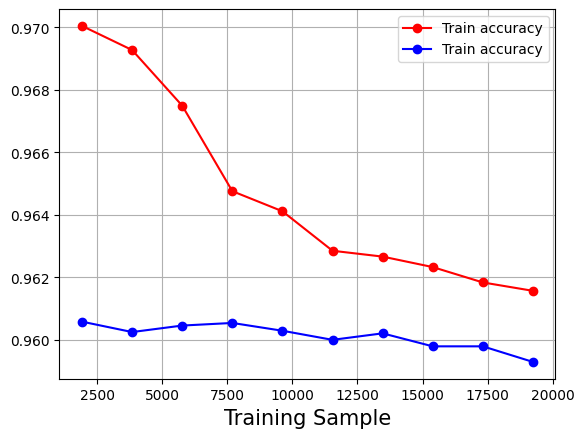

In [26]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=rf_model, 
                                                 X=train_X, 
                                                 y=train_y, 
                                                 train_sizes=np.linspace(.1,1,10),cv=5,
                                                 n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r',marker='o',label='Train accuracy')
plt.plot(size, test_mean, color='b',marker='o',label='Train accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.grid()
plt.legend(loc='upper right')
plt.show()

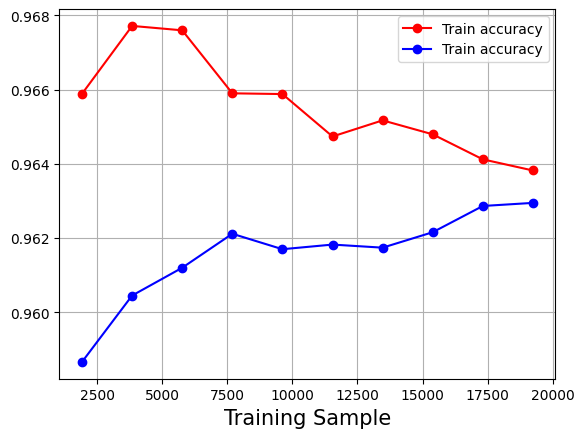

In [27]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=svm_model, 
                                                 X=train_X, 
                                                 y=train_y, 
                                                 train_sizes=np.linspace(.1,1,10),cv=5,
                                                 n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r',marker='o',label='Train accuracy')
plt.plot(size, test_mean, color='b',marker='o',label='Train accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.grid()
plt.legend(loc='upper right')
plt.show()

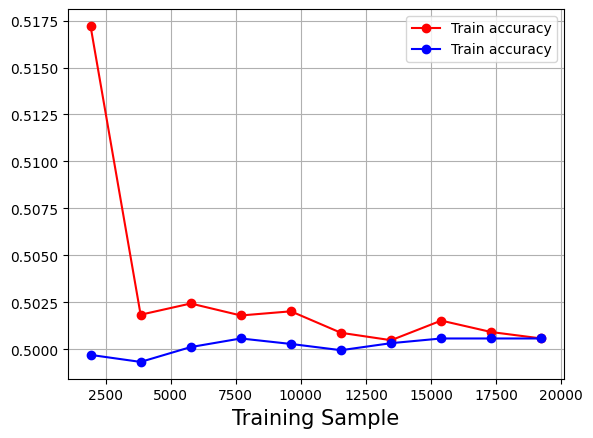

In [28]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=ann_model, 
                                                 X=train_X, 
                                                 y=train_y, 
                                                 train_sizes=np.linspace(.1,1,10),cv=5,
                                                 n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r',marker='o',label='Train accuracy')
plt.plot(size, test_mean, color='b',marker='o',label='Train accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.grid()
plt.legend(loc='upper right')
plt.show()

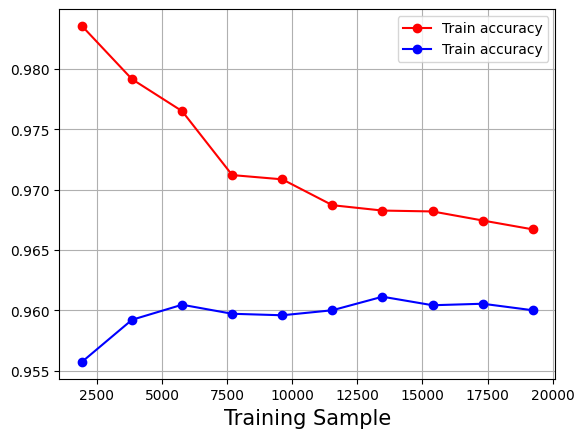

In [33]:
from sklearn.model_selection import learning_curve

size, train_scores, test_scores = learning_curve(estimator=xgb_model, 
                                                 X=train_X, 
                                                 y=train_y, 
                                                 train_sizes=np.linspace(.1,1,10),cv=5,
                                                 n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(size, train_mean, color='r',marker='o',label='Train accuracy')
plt.plot(size, test_mean, color='b',marker='o',label='Train accuracy')
plt.xlabel('Training Sample', fontsize=15)
plt.grid()
plt.legend(loc='upper right')
plt.show()

## TODOs:

- Check Feature Importance, Remove most important features to see if we can fix the prediction accuracy
- Add Writeups
- Get summary Statistics of predictors to create insights
- Scale Data where needed, or scale for all data?